<a href="https://colab.research.google.com/github/Gabriel-git24/cassava_leaf_disease_classification/blob/main/Capstone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = "/content/drive/MyDrive/Capstone Project/archive (5)/split_dataset"
image_size = (224, 224)
batch_size = 32
num_epochs = 20

class_names = [
    "Cassava___bacterial_blight",
    "Cassava___brown_streak_disease",
    "Cassava___green_mottle",
    "Cassava___mosaic_disease",
    "Cassava___healthy"
]

num_classes = len(class_names)

# datagen = ImageDataGenerator(
#     rescale=1./255
# )

# train_generator = datagen.flow_from_directory(
#     f"{data_dir}/train",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=True
# )

# val_generator = datagen.flow_from_directory(
#     f"{data_dir}/val",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=False # WHY IS THIS FALSE HERE?
# )

# test_generator = datagen.flow_from_directory(
#     f"{data_dir}/test",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=False # WHY IS THIS FALSE HERE?
# )

mixed_precision.set_global_policy('mixed_float16')

train_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/val",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_generator = val_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
test_generator = test_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

Found 14975 files belonging to 5 classes.
Found 3207 files belonging to 5 classes.
Found 3215 files belonging to 5 classes.


In [81]:
from tensorflow.keras.applications import ResNet50

def build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5, learning_rate=1e-5):

  base_model = ResNet50(
      weights = "imagenet",
      include_top = False,
      input_shape = input_shape
  )

  #freezing the base layers initially
  base_model.trainable = False

  #defining architecture
  model = models.Sequential([
      #define the input shape
      layers.Input(shape=input_shape),

      # #rescaling
      # layers.Rescaling(1./255),

      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(256, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax", dtype="float32")
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )

  return model


In [82]:
model = build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [83]:
from sklearn.utils import class_weight
import numpy as np

data_dir_train = f"{data_dir}/train"

# Get class names in alphabetical order (same as Keras)
class_names_sorted = sorted([d.name for d in pathlib.Path(data_dir_train).iterdir() if d.is_dir()])

# Count files per class
y_train = []
for idx, class_name in enumerate(class_names_sorted):
    class_path = pathlib.Path(data_dir_train) / class_name
    num_images = len(list(class_path.glob("*")))
    y_train.extend([idx] * num_images)

y_train = np.array(y_train)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(weights))
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(3.9407894736842106), 1: np.float64(1.9549608355091384), 2: np.float64(1.7934131736526946), 3: np.float64(1.661120354963949), 4: np.float64(0.3251900108577633)}


In [84]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Capstone Project/models/resnet_v1.keras",
    save_best_only=True,
    monitor="val_accuracy",
)

early_stopping = EarlyStopping(
   monitor='val_loss',
   patience=5,
   restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.2232 - loss: 2.1102 - val_accuracy: 0.4606 - val_loss: 1.3313 - learning_rate: 1.0000e-05
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3762 - loss: 1.5807 - val_accuracy: 0.5157 - val_loss: 1.2191 - learning_rate: 1.0000e-05
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4604 - loss: 1.4012 - val_accuracy: 0.5429 - val_loss: 1.1602 - learning_rate: 1.0000e-05
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4908 - loss: 1.3262 - val_accuracy: 0.5638 - val_loss: 1.1175 - learning_rate: 1.0000e-05
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5195 - loss: 1.2488 - val_accuracy: 0.5741 - val_loss: 1.0974 - learning_rate: 1.0000e-05
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5423 - loss: 1.2142 - val_accuracy: 0.5822 - val_loss: 1.0777 - learning_rate: 1.0000e-05
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - ac

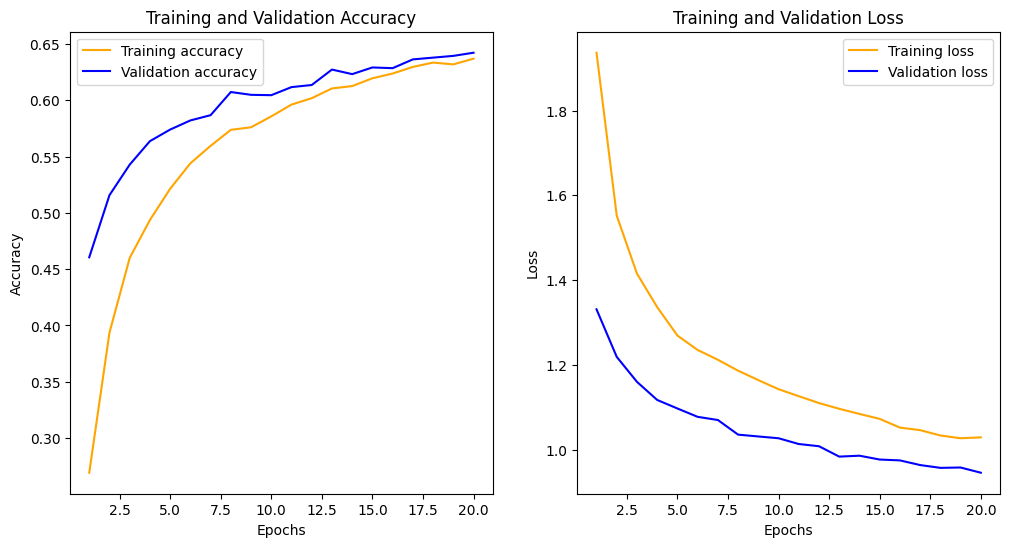

In [85]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'orange', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


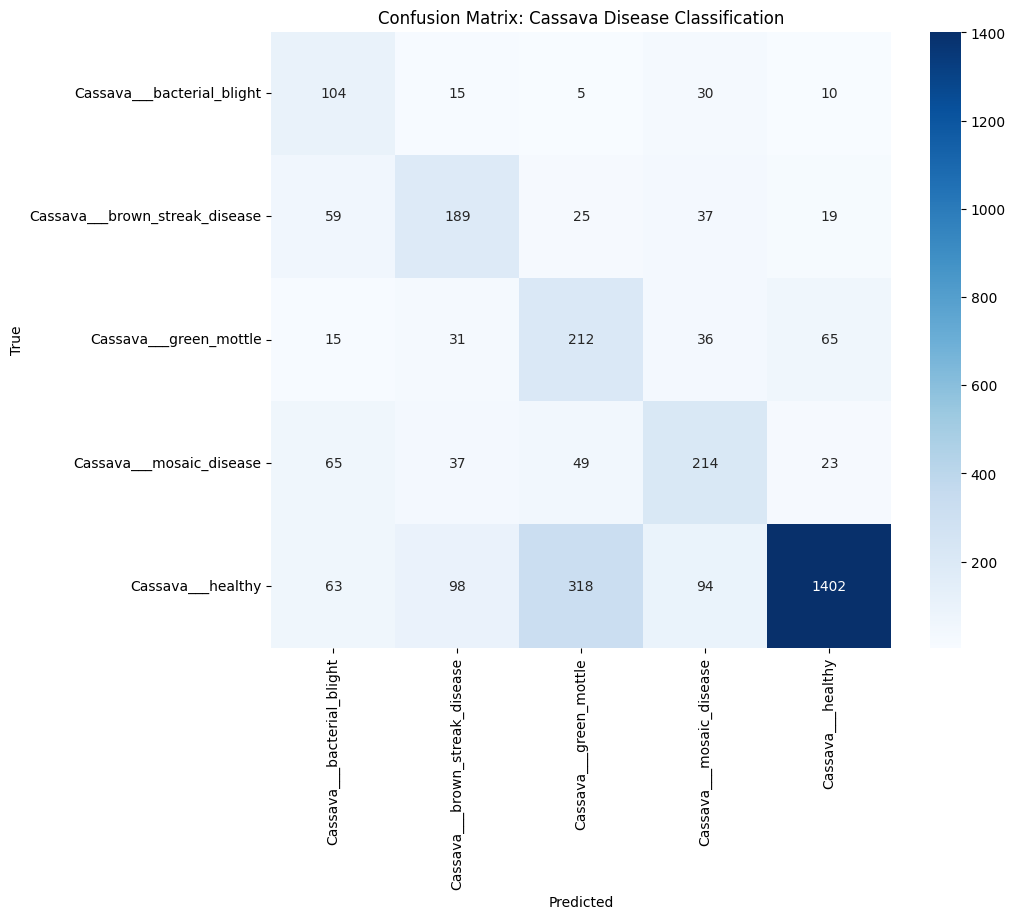

                                precision    recall  f1-score   support

    Cassava___bacterial_blight       0.34      0.63      0.44       164
Cassava___brown_streak_disease       0.51      0.57      0.54       329
        Cassava___green_mottle       0.35      0.59      0.44       359
      Cassava___mosaic_disease       0.52      0.55      0.54       388
             Cassava___healthy       0.92      0.71      0.80      1975

                      accuracy                           0.66      3215
                     macro avg       0.53      0.61      0.55      3215
                  weighted avg       0.74      0.66      0.68      3215



In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Extract true labels
y_true = np.concatenate([y for x, y in test_generator], axis=0)

# FIX: Correct check for one-hot encoding (check number of dimensions)
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# 2. Predict
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# 2. Identify which classes are actually present in your test data
# (This finds which of the 0-4 indices actually exist in y_true)
present_indices = np.unique(y_true).astype(int)
actual_labels = [class_names[i] for i in present_indices]

# 3. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=actual_labels,
            yticklabels=actual_labels)



plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Cassava Disease Classification')
plt.show()

# 5. Classification Report
# We use actual_labels to ensure the count matches the 4 classes found
print(classification_report(y_true, y_pred, target_names=actual_labels))